In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import linalg as lin
plt.style.use('seaborn-whitegrid')
from tqdm import tqdm
%matplotlib inline

In [2]:
#####  Function to compute time for wall collision ######
def wall_time(coord, velcomp, rad):  
    if velcomp > 0.0:
        del_t = (1.0 - rad - coord) / velcomp
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp)
    else:
        del_t = float('inf')
    return del_t


# Function to calculate time it takes for a pair of particles to collide. 
# pos1 and pos2 are positions of particles 1 and 2, vel1 and vel2 are their 
# velocities. rad is the radius of the particles. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2)
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t


# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc="r")
        plt.gca().add_patch(atom)

In [3]:
def x_component(positions):
    A = []
    for i in range(len(positions)):
        a = positions[i][0] 
        A.append(a)
    return np.array(A)

In [4]:
#This function calculates the coordinates of intersection points of a regular grid pattern. 
#These coordinates are used to fix the initial position-configuration of the disks. 
def positions_f(N_atoms):
    global Ratom
    
    density = 0.2 # Fraction of the area of the box covered by the disks
    Ratom = np.sqrt(density/(N_atoms*np.pi))   ## Radius of disk.
    
    spacing = 1/(np.sqrt(N_atoms)+1)
    
    x_spacings = np.linspace(0+spacing,1-spacing,int(np.sqrt(N_atoms)))
    y_spacings = x_spacings
    
    position_list = np.array([(i,j) for i in x_spacings for j in y_spacings])
    
    return position_list

In [5]:
#By using random numbers between 0 and 1 as the x and y velocity components,  
#the function generates the initial velocity list for the particles.
def velocities_f(N_atoms):
    velocity_list = np.array([(random.random(),random.random()) for i in range(N_atoms)])
    return velocity_list

In [6]:
def evolve(t,next_event,positions,velocities):
    global x_components_list
    
    pos = np.copy(positions)
    vel = np.copy(velocities)
    if t+next_event >= int(t)+1:
        t_previous = t
        for snapshot_instant in range(int(t)+1,int(t)+2):
            delta_t = snapshot_instant - t_previous
            for i in range(Natoms):
                pos[i] += vel[i]*delta_t
            t_previous = snapshot_instant
            x_components_list = np.append(x_components_list,x_component(pos))

In [7]:
######################### Initialization #################################
L = 1. ## Box edge length
Natoms = 4 # Number of disks

## List indexing all pairs of atoms.
pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 

t = 0
n_events = 1000000

In [8]:
positions = positions_f(Natoms)
velocities = velocities_f(Natoms)

x_components_list = np.array([]) 
time_list=[]

In [9]:
 ############### Event Loop ##############################################

for event in tqdm(range(n_events)):
    # Wall collision times for all disks and their velocity components.
    wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)] 
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.
    next_event = min(wall_times + pair_times) 
    
    if event> 500:
        evolve(t,next_event,positions,velocities)
        
    t += next_event 
    for i in range(Natoms):
        positions[i] += velocities[i]*next_event # Evolve positions to collision event
        
    if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall
        wall_index = wall_times.index(next_event)
        particle, component = divmod(wall_index, 2)
        velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp
##################################################################################

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:58<00:00, 8453.38it/s]


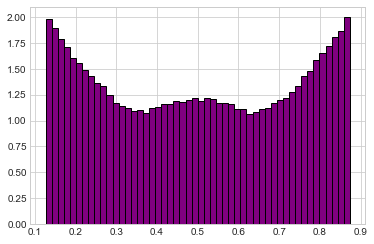

In [10]:
n_bins = 50
plt.hist(x_components_list, bins = n_bins, density=True, color='purple', edgecolor='black');

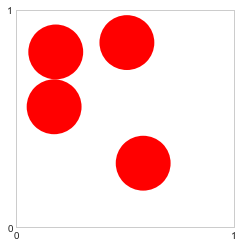

In [11]:
create_picture(positions)

In [12]:
len(x_components_list)/4

92775.0